In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from pybedtools import BedTool
import numpy as np
import re
from lad_utils import *

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')

In [2]:
# this is generated by the HMM

lb1_all_cts = pd.read_table('LB1_HMM_predictions/LB1_dat_3state.tsv')

h3k9me2_all_cts = pd.read_table('H3K9me2_HMM_predictions/H3K9me2_dat_2state.tsv')

lb1_cats = []

h3k9me2_cats = []

for ct in lb1_all_cts['cell_type'].unique():
    categorized = assign_categories(lb1_all_cts.query('cell_type == @ct').copy(), ['nonLAD','T2-LAD','T1-LAD'])
    lb1_cats.append(categorized)
    
lb1_dat = pd.concat(lb1_cats, sort=False)
# lb1_dat_bed = BedTool.from_dataframe(lb1_dat[['chrom','start','stop','id']])


for ct in h3k9me2_all_cts['cell_type'].unique():
    categorized = assign_categories(h3k9me2_all_cts.query('cell_type == @ct').copy(),
                                   ['nonKDD','KDD'])
    h3k9me2_cats.append(categorized)
    
h3k9me2_dat = pd.concat(h3k9me2_cats, sort=False) 
# h3k9me2_dat_bed = BedTool.from_dataframe(h3k9me2_dat[['chrom','start','stop','id']])



lb1_h3k9me2_merged_dat = lb1_dat.merge(h3k9me2_dat, 
                                       on=['chrom','start','stop','cell_type'], 
                                       how='inner',
                                      suffixes=('_LAD','_KDD'))

lads_kdds = lb1_h3k9me2_merged_dat[['chrom','start','stop','cell_type','category_LAD', 'category_KDD']].copy()

lads_kdds['id'] = lads_kdds.index

bins_bed = BedTool.from_dataframe(lads_kdds[['chrom','start','stop','id']]).sort()



# get feature enrichments

In [3]:
# Kallisto analysis used Ensembl gene annotations v96, should do that here as well for continuity

ensembl = pd.read_csv('Homo_sapiens.GRCh38.96.gtf',
                     sep='\t', skiprows=5, header=None, 
                      names=['chrom','source','desc','start','end','score','strand','score2','desc_further'],
                     low_memory=False)
ensembl['chr'] = 'chr' + ensembl['chrom'].astype(str)
ensembl['name'] = ensembl['desc_further'].str.split('gene_name ').str[1].str.split(';').str[0].str.strip('""')

# filter for genes only

ensembl_genes = ensembl.query('desc == "gene"').copy()
n_ens_genes = pd.DataFrame(ensembl_genes['name'].value_counts())
n_ens_genes['gene'] = n_ens_genes.index
ensembl_genes_single = n_ens_genes.query('name == 1')['gene'].tolist()
ensembl_genes_single_df = ensembl_genes.query('(name in @ensembl_genes_single)').copy()

# make BED file

ens_single_bed = BedTool.from_dataframe(ensembl_genes_single_df[['chr','start','end','name']].copy()).sort()



In [4]:
kdd_to_rna = {
    'CardiacMyocytes':'VentricularCM',
    'H9ESC':'H9ESC',
    'EarlySomite':'EarlySomite',
    'ParaxMesoderm':'ParaxMesoderm',
    'MidHindgut':'MidHindgut',
    'EndoProgenitor':'D15EC',
    'DefEctoderm':'NeuralEctoderm'
}

kdd_to_atac = {
    'CardiacMyocytes':'_H9_30_',
    'H9ESC':'_H9_0_',
    'ParaxMesoderm':'_H9_2_'
}

def b_comp(ct):
    
    b_compartment = BedTool(f'ab_compartment_comparisons/{ct}_B_compartment.bed').sort()

    return(b_compartment)

def load_atac(atac_ct):
    
    rep1_f = [ i for i in os.listdir('atac_dat/GSE85330/') if f'{atac_ct}1' in i ][0]
    
    rep1 = BedTool.from_dataframe(pd.read_table(f'atac_dat/GSE85330/{rep1_f}',
                                                header=None, names=['chrom','start','end','name',
                                                                    'score','strand','score2',
                                                                    'score3','score4','score5'])[['chrom','start','end']]).sort().liftover('/pollard/data/functional_genomics/liftOver/hg19ToHg38.over.chain.gz').sort()

    rep2_f = [ i for i in os.listdir('atac_dat/GSE85330/') if f'{atac_ct}2' in i ][0]
    
    rep2 = BedTool.from_dataframe(pd.read_table(f'atac_dat/GSE85330/{rep2_f}',
                                                header=None, names=['chrom','start','end','name',
                                                                    'score','strand','score2',
                                                                    'score3','score4','score5'])[['chrom','start','end']]).sort().liftover('/pollard/data/functional_genomics/liftOver/hg19ToHg38.over.chain.gz').sort()
    tog = rep1.intersect(rep2).sort().merge()
    
    return(tog)

def get_enrichment_special(feature, lad_cat, kdd_cat, dat):

    counts = np.array([[len(dat.query(f'{feature} and (category_LAD == @lad_cat and category_KDD == @kdd_cat)')),
              len(dat.query(f'~{feature} and (category_LAD == @lad_cat and category_KDD == @kdd_cat)'))],
             [len(dat.query(f'{feature} and ~(category_LAD == @lad_cat and category_KDD == @kdd_cat)')),
              len(dat.query(f'~{feature} and ~(category_LAD == @lad_cat and category_KDD == @kdd_cat)'))]])

    odds, pval = stats.fisher_exact(counts)
    
    return(odds, pval, f'{lad_cat}&{kdd_cat}') 

In [5]:
# gene overlap

bins_genes = bins_bed.intersect(ens_single_bed, u=True).to_dataframe()['name'].drop_duplicates().tolist()
lads_kdds['overlaps_gene'] = lads_kdds['id'].isin(bins_genes)

# expressed gene overlap for cell types with matched RNAseq data

for val in kdd_to_rna.keys():
    exp_genes = pd.read_table('RNAseq_quantile_normalized_dat.tsv').merge(ensembl_genes_single_df[['chrom','start','end','name']], left_on='gene_ID', right_on='name', how='left').query(f'tpm_{kdd_to_rna[val]} > 0.0')
    exp_genes['chr'] = 'chr' + exp_genes['chrom'].astype(str)
    exp_genes_bed = BedTool.from_dataframe(exp_genes[['chr','start','end','name',f'tpm_{kdd_to_rna[val]}']]).sort()
    # need to only get expressed gene overlap in cell types that have matched RNAseq data
    ladkdd_dat_bed_ect = BedTool.from_dataframe(lads_kdds.query('cell_type == @val').copy()[['chrom','start','stop','id']])
    ladkdd_exp_genes =  ladkdd_dat_bed_ect.intersect(exp_genes_bed, u=True).to_dataframe()['name'].drop_duplicates().tolist() 
    lads_kdds[f'overlaps_expressed_gene_{val}'] = lads_kdds['id'].isin(ladkdd_exp_genes)
    
# atacseq overlap for cell types with matched ATACseq data

for val in kdd_to_atac.keys():
    atac_peaks = load_atac(kdd_to_atac[val])
    # need to only get expressed gene overlap in cell types that have matched RNAseq data
    ladkdd_dat_bed_ect = BedTool.from_dataframe(lads_kdds.query('cell_type == @val').copy()[['chrom','start','stop','id']])
    ladkdd_atac =  ladkdd_dat_bed_ect.intersect(atac_peaks, u=True).to_dataframe()['name'].drop_duplicates().tolist() 
    lads_kdds[f'overlaps_atac_{val}'] = lads_kdds['id'].isin(ladkdd_atac)
   
# b compartment overlap for cell types w/ matched Hi-C

for val in ['H9ESC','CardiacMyocytes']:
    bcomp = b_comp(val)
    ladkdd_dat_bed_ect = BedTool.from_dataframe(lads_kdds.query('cell_type == @val').copy()[['chrom','start','stop','id']])
    ladkdd_bcomp = ladkdd_dat_bed_ect.intersect(bcomp, u=True).to_dataframe()['name'].drop_duplicates().tolist() 
    lads_kdds[f'overlaps_bcomp_{val}'] = lads_kdds['id'].isin(ladkdd_bcomp)  
    
    

In [6]:
ors = []
pvals = []
cats = []
cts = []
features = []

for lad_cat in ['T1-LAD','T2-LAD','nonLAD']:
    for kdd_cat in ['nonKDD','KDD']:
        for ct in all_cts:
            # gene overlap
            cts.append(ct)
            out_or, out_pval, out_cat = get_enrichment_special('overlaps_gene', lad_cat, kdd_cat, lads_kdds.query('cell_type == @ct'))
            ors.append(out_or)
            pvals.append(out_pval)
            cats.append(out_cat)
            features.append('gene')
        for ct in kdd_to_rna.keys():
            # expressed gene overlap
            cts.append(ct)
            out_or, out_pval, out_cat = get_enrichment_special(f'overlaps_expressed_gene_{ct}', lad_cat, kdd_cat, lads_kdds.query('cell_type == @ct'))
            ors.append(out_or)
            pvals.append(out_pval)
            cats.append(out_cat)
            features.append('expressed_gene')
        for ct in kdd_to_atac.keys():
            # ATAC overlap
            cts.append(ct)
            out_or, out_pval, out_cat = get_enrichment_special(f'overlaps_atac_{ct}', lad_cat, kdd_cat, lads_kdds.query('cell_type == @ct'))
            ors.append(out_or)
            pvals.append(out_pval)
            cats.append(out_cat)
            features.append(f'ATAC')
        for ct in ['H9ESC','CardiacMyocytes']:
            # B compartment overlap
            cts.append(ct)
            out_or, out_pval, out_cat = get_enrichment_special(f'overlaps_bcomp_{ct}', lad_cat, kdd_cat, lads_kdds.query('cell_type == @ct'))
            ors.append(out_or)
            pvals.append(out_pval)
            cats.append(out_cat)
            features.append('B_compartment')
        
        
        

In [7]:
enrichments_overall = pd.DataFrame({
    'odds_ratio':ors,
    'fishers_p':pvals,
    'category':cats,
    'cell_type':cts,
    'feature':features
})

enrichments_overall['-log10(P-value)'] = -enrichments_overall['fishers_p'].map(np.log10)
enrichments_overall = enrichments_overall.replace(np.inf, 300)



/pollard/home/kathleen/miniconda3/envs/LAD_analysis/lib/python3.7/site-packages/pandas/core/base.py:1300: RuntimeWarning: divide by zero encountered in log10
  new_values = map_f(values, mapper)


In [8]:
enrichments_overall.head()

,odds_ratio,fishers_p,category,cell_type,feature,-log10(P-value)
0,0.303432,1.296322e-64,T1-LAD&nonKDD,CardiacMyocytes,gene,63.887287
1,0.251395,0.000000e+00,T1-LAD&nonKDD,EarlySomite,gene,300.000000
2,0.418665,1.115313e-53,T1-LAD&nonKDD,H9ESC,gene,52.952603
3,0.434442,1.373858e-210,T1-LAD&nonKDD,ParaxMesoderm,gene,209.862058
4,0.395729,0.000000e+00,T1-LAD&nonKDD,DefEctoderm,gene,300.000000


In [9]:
def pval_cats(val):
    if val < 2:
        return('<2')
    else:
        return('>2')

enrichments_overall['pvals'] = enrichments_overall['-log10(P-value)'].map(pval_cats)

size_dict = {
    '<2':20,
    '>2':100
}

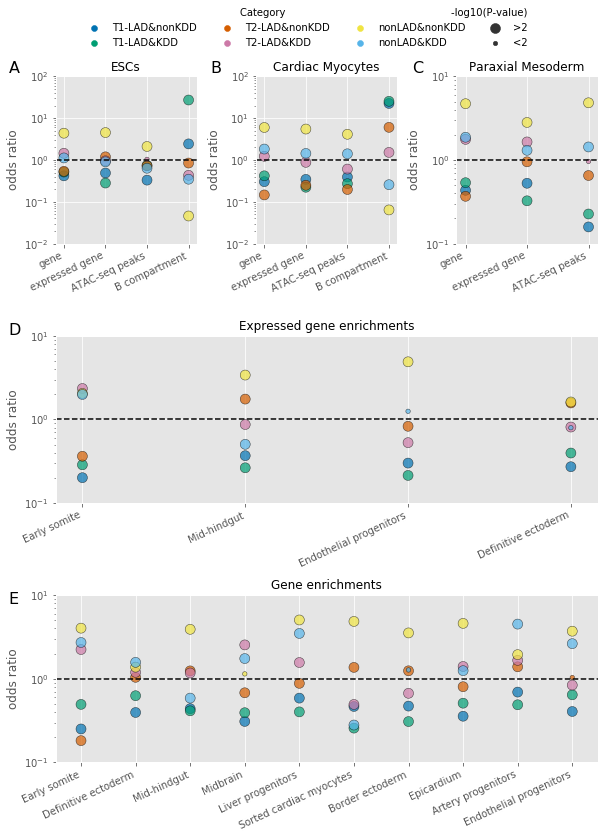

In [12]:
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')

fig = plt.figure(figsize=(8.5, 11))

gs = mpl.gridspec.GridSpec(3, 3, width_ratios=[1, 1, 1],
                          height_ratios=[1, 1, 1])

# linewidth

lw=0.5
label_pad = 0.05

# panel A: feature enrichments, H9ESCs

axA = plt.subplot(gs[0,0])

sns.scatterplot(x='feature', y='odds_ratio', 
                    data=enrichments_overall.query('cell_type == "H9ESC"').replace(ct_replace).replace({'B_compartment':'B compartment',
                                                                                                        'expressed_gene':'expressed gene',
                                                                                                       'ATAC':'ATAC-seq peaks'}), 
                size='pvals',
                   hue='category', 
                    sizes=size_dict, 
                    edgecolor='black', hue_order = ['T1-LAD&nonKDD', 'T1-LAD&KDD', 'T2-LAD&nonKDD', 'T2-LAD&KDD',
       'nonLAD&nonKDD', 'nonLAD&KDD'],
               ax=axA, linewidth=lw, alpha=0.7)

axA.set(yscale='log', ylim=(0.01, 100),
        ylabel='odds ratio', xlabel='', title='ESCs')
axA.axhline(1, linestyle='dashed', color='black')

axA.legend(loc='upper left', ncol=2, frameon=False)
axA.get_legend().remove()

# panel B: feature enrichments, Cardiac Myocytes

axB = plt.subplot(gs[0,1])

sns.scatterplot(x='feature', y='odds_ratio', 
                    data=enrichments_overall.query('cell_type == "CardiacMyocytes"').replace(ct_replace).replace({'B_compartment':'B compartment',
                                                                                                        'expressed_gene':'expressed gene',
                                                                                                       'ATAC':'ATAC-seq peaks'}), 
                size='pvals',
                   hue='category', 
                    sizes=size_dict, 
                    edgecolor='black', hue_order = ['T1-LAD&nonKDD', 'T1-LAD&KDD', 'T2-LAD&nonKDD', 'T2-LAD&KDD',
       'nonLAD&nonKDD', 'nonLAD&KDD'],
               ax=axB, linewidth=lw, alpha=0.7)

axB.set(yscale='log', ylim=(0.01, 100),
        ylabel='odds ratio', xlabel='', title='Cardiac Myocytes')
axB.axhline(1, linestyle='dashed', color='black')
axB.get_legend().remove()

# panel C: feature enrichments, ParaxMesoderm

axC = plt.subplot(gs[0,2])

sns.scatterplot(x='feature', y='odds_ratio', 
                    data=enrichments_overall.query('cell_type == "ParaxMesoderm"').replace(ct_replace).replace({'B_compartment':'B compartment',
                                                                                                        'expressed_gene':'expressed gene',
                                                                                                       'ATAC':'ATAC-seq peaks'}), 
                size='pvals',
                   hue='category', 
                    sizes=size_dict, 
                    edgecolor='black', hue_order = ['T1-LAD&nonKDD', 'T1-LAD&KDD', 'T2-LAD&nonKDD', 'T2-LAD&KDD',
       'nonLAD&nonKDD', 'nonLAD&KDD'],
               ax=axC, linewidth=lw, alpha=0.7)

axC.set(yscale='log', ylim=(0.1, 10),
        ylabel='odds ratio', xlabel='', title='Paraxial Mesoderm')
axC.axhline(1, linestyle='dashed', color='black')
axC.get_legend().remove()

# panel D: feature enrichments, expressed gene


axD = plt.subplot(gs[1, 0:3])

sns.scatterplot(x='cell_type', y='odds_ratio', 
                    data=enrichments_overall.query('((cell_type == "EarlySomite") or (cell_type == "DefEctoderm") or (cell_type == "MidHindgut") or (cell_type == "EndoProgenitor")) and (feature == "expressed_gene")').replace(ct_replace).replace({'B_compartment':'B compartment',
                                                                                                        'expressed_gene':'expressed gene',
                                                                                                       'ATAC':'ATAC-seq peaks'}), 
                size='pvals',
                   hue='category', 
                    sizes=size_dict,
                    edgecolor='black', hue_order = ['T1-LAD&nonKDD', 'T1-LAD&KDD', 'T2-LAD&nonKDD', 'T2-LAD&KDD',
       'nonLAD&nonKDD', 'nonLAD&KDD'],
               ax=axD, linewidth=lw, alpha=0.7)

axD.set(yscale='log', ylim=(0.1, 10),
        ylabel='odds ratio', xlabel='', title='Expressed gene enrichments')
axD.axhline(1, linestyle='dashed', color='black')
axD.legend(loc='upper left', ncol=4)
axD.get_legend().remove()

# panel E: gene enrichments, remaining cell types

gene_only_cts = ['EarlySomite', 'DefEctoderm','MidHindgut','EndoProgenitor',
                 'D5Midbrain', 'Liver', 'SortedCM', 
                 'BorderEctoderm', 'Epicardium', 'D4Artery']

axE = plt.subplot(gs[2, 0:3])

sns.scatterplot(x='cell_type', y='odds_ratio', 
                    data=enrichments_overall.query('(cell_type in @gene_only_cts) and (feature == "gene")').replace(ct_replace),
                size='pvals',
                   hue='category', 
                    sizes=size_dict,
                    edgecolor='black', hue_order = ['T1-LAD&nonKDD', 'T1-LAD&KDD', 'T2-LAD&nonKDD', 'T2-LAD&KDD',
       'nonLAD&nonKDD', 'nonLAD&KDD'],
               ax=axE, linewidth=lw, alpha=0.7)

axE.set(yscale='log', ylim=(0.1, 10),
        ylabel='odds ratio', xlabel='', title='Gene enrichments')
axE.axhline(1, linestyle='dashed', color='black')
axE.get_legend().remove()

for ax in [axA, axB, axC, axD, axE]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(12)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(10)
    for tick in ax.get_xticklabels():
        tick.set_rotation(25)
        tick.set_ha('right')
    
# add overall figure legend with colors to LAD categories
    
lines, labels = axA.get_legend_handles_labels()
lines = lines[1:7] + lines[8:]
labels = labels[1:7] + labels[8:]
leg = fig.legend(lines, labels, loc='upper center',
           frameon=False, title='Category                                                     -log10(P-value)',
          ncol=4, bbox_to_anchor=(0.5, 1.06))
leg._legend_box.align = "right"

# add panel labels

fig.text(0.02, 0.97, 'A', fontsize=16,
         ha='left')
fig.text(0.35, 0.97, 'B', fontsize=16,
         ha='left')
fig.text(0.68, 0.97, 'C', fontsize=16,
         ha='left')
fig.text(0.02, 0.64, 'D', fontsize=16,
         ha='left')
fig.text(0.02, 0.3, 'E', fontsize=16,
         ha='left')

fig.tight_layout()

In [ ]:
fig.savefig('../figs/r2r_Fig5_LAD_v_KDD_feature_enrichments_mult_celltypes_low_res.png',
           dpi=100, bbox_inches='tight')


In [13]:
fig.savefig('../figs/r2r_Fig5_LAD_v_KDD_feature_enrichments_mult_celltypes.png',
           dpi=300, bbox_inches='tight')


In [102]:
fig.savefig('../figs/r2r_Fig5_LAD_v_KDD_feature_enrichments_mult_celltypes.png',
           dpi=300, bbox_inches='tight')

fig.savefig('../figs/r2r_Fig5_LAD_v_KDD_feature_enrichments_mult_celltypes.pdf',
           dpi=300, bbox_inches='tight')

# supp fig with RT domains

In [11]:
rt_df = pd.read_csv('replication_timing/constitutive_dev_domains/hg38_labels_NatGenetics2018/Human_NormalCellTypes_48datasets_hg38_50KB-qunatilescaled_label_0.15_threshold.txt',
                sep='\t')

rt_df['switch'] = rt_df['switch'].replace(np.nan, 'NA')
rt_df['END'] = rt_df['POS'] + 50000

switch_domains = BedTool.from_dataframe(rt_df.query('switch == "S"').copy()[['CHR','POS','END','switch']])
cl_domains = BedTool.from_dataframe(rt_df.query('switch == "CL"').copy()[['CHR','POS','END','switch']])
ce_domains = BedTool.from_dataframe(rt_df.query('switch == "CE"').copy()[['CHR','POS','END','switch']])
unclassified = BedTool.from_dataframe(rt_df.query('switch == "NA"').copy()[['CHR','POS','END','switch']])

In [12]:
dat_switch = bins_bed.intersect(switch_domains, u=True).to_dataframe()['name'].drop_duplicates().tolist()
dat_cl = bins_bed.intersect(cl_domains, u=True).to_dataframe()['name'].drop_duplicates().tolist()
dat_ce = bins_bed.intersect(ce_domains, u=True).to_dataframe()['name'].drop_duplicates().tolist()

In [13]:
lads_kdds['overlaps_switch'] = lads_kdds['id'].isin(dat_switch)
lads_kdds['overlaps_cl'] = lads_kdds['id'].isin(dat_cl)
lads_kdds['overlaps_ce'] = lads_kdds['id'].isin(dat_ce)



In [34]:
ors = []
pvals = []
cats = []
cts = []
features = []

for lad_cat in ['T1-LAD','T2-LAD','nonLAD']:
    for kdd_cat in ['nonKDD','KDD']:
        for ct in all_cts:
            for feature in ['switch','cl','ce']:
                # gene overlap
                cts.append(ct)
                out_or, out_pval, out_cat = get_enrichment_special(f'overlaps_{feature}', lad_cat, kdd_cat, lads_kdds.query('cell_type == @ct'))
                ors.append(out_or)
                pvals.append(out_pval)
                cats.append(out_cat)
                features.append(feature)

In [59]:
enrichments_overall = pd.DataFrame({
    'odds_ratio':ors,
    'fishers_p':pvals,
    'category':cats,
    'cell_type':cts,
    'feature':features
})

enrichments_overall['-log10(P-value)'] = -enrichments_overall['fishers_p'].map(np.log10)
enrichments_overall = enrichments_overall.replace(np.inf, 300).replace({
        'cl':'Constitutive late',
        'switch':'Switch',
        'ce':'Constitutive early'
    })



/pollard/home/kathleen/miniconda3/envs/LAD_analysis/lib/python3.7/site-packages/pandas/core/base.py:1300: RuntimeWarning: divide by zero encountered in log10
  new_values = map_f(values, mapper)


In [60]:
enrichments_overall.head()

,odds_ratio,fishers_p,category,cell_type,feature,-log10(P-value)
0,0.462909,8.196073e-26,T1-LAD&nonKDD,CardiacMyocytes,Switch,25.086394
1,0.057334,3.164964e-39,T1-LAD&nonKDD,CardiacMyocytes,Constitutive late,38.499631
2,0.015919,3.517844e-68,T1-LAD&nonKDD,CardiacMyocytes,Constitutive early,67.453723
3,0.162249,0.000000e+00,T1-LAD&nonKDD,EarlySomite,Switch,300.000000
4,0.539307,1.828308e-28,T1-LAD&nonKDD,EarlySomite,Constitutive late,27.737951


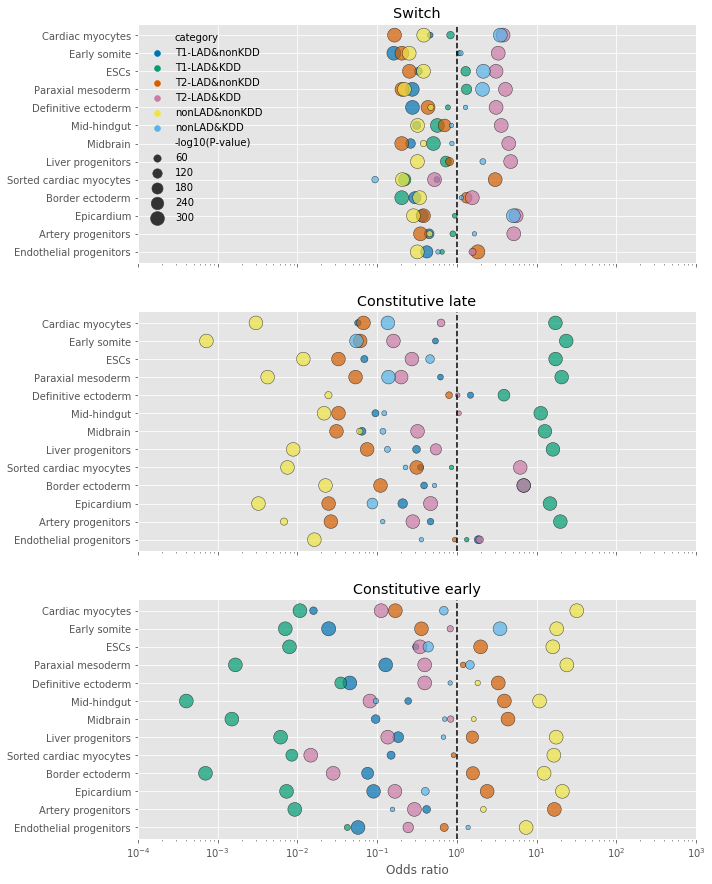

In [64]:
lw=0.5

fig, axs = plt.subplots(3, 1, figsize=(10,15), sharex=True, sharey=False)

counter = 0
for feature in enrichments_overall['feature'].unique():
    ax = axs[counter]

    sns.scatterplot(y='cell_type', x='odds_ratio', 
                        data=enrichments_overall.query('feature == @feature').replace(ct_replace),
                    size='-log10(P-value)',
                       hue='category', 
                        sizes=(20, 200),
                        edgecolor='black', hue_order = ['T1-LAD&nonKDD', 'T1-LAD&KDD', 'T2-LAD&nonKDD', 'T2-LAD&KDD',
           'nonLAD&nonKDD', 'nonLAD&KDD'],
                   linewidth=lw, alpha=0.7, ax=ax)
    ax.set(xscale='log', xlim=(0.0001, 1000))
#     plt.xticks(rotation=45, ha='right')
#     plt.legend(loc='upper left', ncol=2, frameon=False)
    ax.axvline(1, linestyle='dashed', color='black')
    ax.get_legend().remove()
    ax.set(ylabel='', xlabel='Odds ratio', title=feature)
    
    if counter == 0:
        ax.legend(loc='upper left', frameon=False)
    
    counter += 1

In [65]:
fig.savefig('../figs/SF10_rt_domain_enrichments_low_res.png',
           dpi=100, bbox_inches='tight')

fig.savefig('../figs/SF10_rt_domain_enrichments.pdf',
           dpi=300, bbox_inches='tight')